# Vessel segmentation in retina fundus images (revisited)

In this assignment, we are going to develop a system to automatically **segment vessels** in human retina fundus images (again).

In assignment 2 we trained a classical classification algorithm based on a Gaussian filterbank and a kNN classifier.
This time we are going to use convolutional neural networks to solve the same task!

We are going to use the same data from the publicly available DRIVE dataset (http://www.isi.uu.nl/Research/Databases/DRIVE/).
The DRIVE dataset consists of 40 images, 20 used for training and 20 used for testing. Each case contains:
* fundus (RGB) image
* a binary mask, which indicates the area of the image that has to be analyzed (removing black background)
* manual annotations of retina vessels, provided as a binary map.

You can download the data for this assignment from this link: https://surfdrive.surf.nl/files/index.php/s/VZnaAZ8GWTZCCka (password: ismi2017)

## Tasks for this assignment

1. Develop a system to segment vessels in retina image in this notebook. You will have to submit this notebook with your code, which we will run and evaluate, together with the results of the segmentation.
2. Use the training set provided with the DRIVE dataset to train/tune the parameters of your system. You cannot use data from the test set available on the DRIVE website, nor from other datasets. 
3. Apply it to the test dataset and generate a binary map of the segmented vessel. The map must have the same size as the input image.
4. Submit the results of the notebook to the mini-challenge framework by running the corresponding cell in this notebook (at the end of the notebook). This will automatically submit your results to the mini-challenge framework. You will be able to visualize your scores in the **CHALLENGE** section of the webpage (http://ismi17.diagnijmegen.nl/). Note that after you submit the notebook, we will run your implementation and reproduce your result in order to evaluate your assignment. Any significant discrepancy between the results submitted to the mini-challenge framework and the one computed using this notebook will be penalized and discussed with the student.

### Mandatory tasks
* Implement the ```Sample_extractor``` class
    * Random rotation augmentation
    * Random flipping augmentation
    
    
* Implement the ```Batch_extractor``` class


* Implement a fully convolutional network
    * Train your network


* Implement the shift and stitch method

* Submit your results to ```challengr```

### Optional tasks
* Implement additional data augmentation strategies and show if they can improve the performance


## Implementation 

First we import some neccesary libraries:

In [1]:
# import libraries needed for this assignment
import os
import numpy as np
from PIL import Image
from scipy.ndimage.interpolation import affine_transform
from math import cos, sin, radians, floor, ceil

import theano
import theano.tensor as T
import lasagne
import lasagne.layers as L

import random

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 12)
from IPython import display
import time
# from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

from challenger import submit_results


Using gpu device 0: GeForce GTX 850M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5005)
/home/nat/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# function to get a list of file of a given extension, both the absolute path and the filename
def get_file_list(path,ext='',queue=''):
    if ext != '':
        return [os.path.join(path,f) for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')],  [f for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')]    
    else:
        return [os.path.join(path,f) for f in os.listdir(path)]

Point to the local copy of training data.

Set ```data_dir``` to the location of the folder containing the DRIVE data

In [3]:
data_dir = "./DRIVE/"

tra_img_dir = os.path.join(data_dir, 'training', 'images')
tra_msk_dir = os.path.join(data_dir, 'training', 'mask')
tra_lbl_dir = os.path.join(data_dir, 'training', '1st_manual')

tra_imgs_all = sorted(get_file_list(tra_img_dir, 'tif')[0])
tra_msks_all = sorted(get_file_list(tra_msk_dir, 'gif')[0])
tra_lbls_all = sorted(get_file_list(tra_lbl_dir, 'gif')[0])

Split the data in a training and validation set.

In [4]:
# split training set in a training and validation set
# >>> YOUR CODE STARTS HERE <<<
validation_percentage = 0.3
# >>> YOUR CODE ENDS HERE <<<  

n_validation_images = int(ceil(len(tra_imgs_all)*validation_percentage))

# use the first images as validation
val_imgs = tra_imgs_all[0:n_validation_images]
val_msks = tra_msks_all[0:n_validation_images]
val_lbls = tra_lbls_all[0:n_validation_images]

# the rest as training
tra_imgs = tra_imgs_all[n_validation_images:]
tra_msks = tra_msks_all[n_validation_images:]
tra_lbls = tra_lbls_all[n_validation_images:]

print "nr of training images: " + str(len(tra_imgs)) + "\nnr of validation images: " + str(len(val_imgs))

nr of training images: 14
nr of validation images: 6


Define a function to visualize (1) the fundus image, (2) the binary mask, (3) the manual annotation of a case with a given index.

In [5]:
def show_image(idx, imgs, msks, lbls):
    img = np.asarray(Image.open(imgs[idx]))
    print img.shape
    msk = np.asarray(Image.open(msks[idx]))
    lbl = np.asarray(Image.open(lbls[idx]))
    plt.subplot(1,3,1)
    plt.imshow(img); plt.title('RGB image {}'.format(idx+1))
    plt.subplot(1,3,2)
    plt.imshow(msk, cmap='gray'); plt.title('Mask {}'.format(idx+1))
    plt.subplot(1,3,3)
    plt.imshow(lbl, cmap='gray'); plt.title('Manual annotation {}'.format(idx+1))
    plt.show()

Show the training set using the function defined

(584, 565, 3)


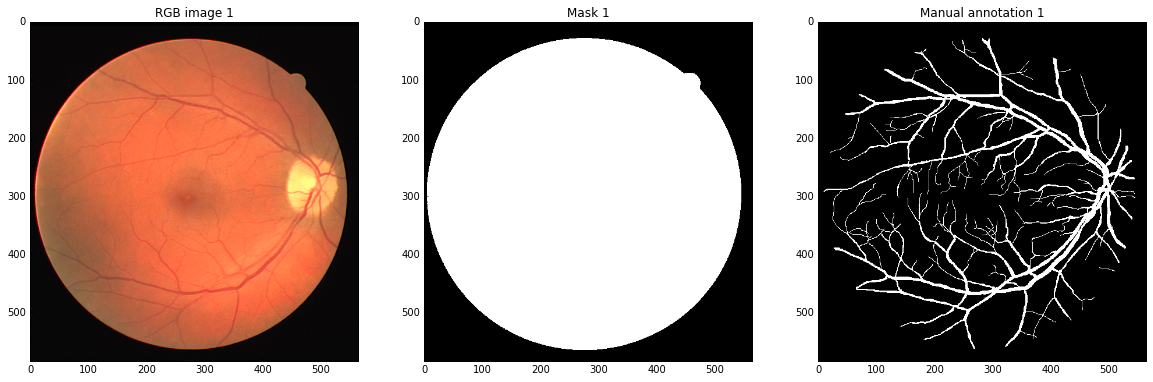

(584, 565, 3)


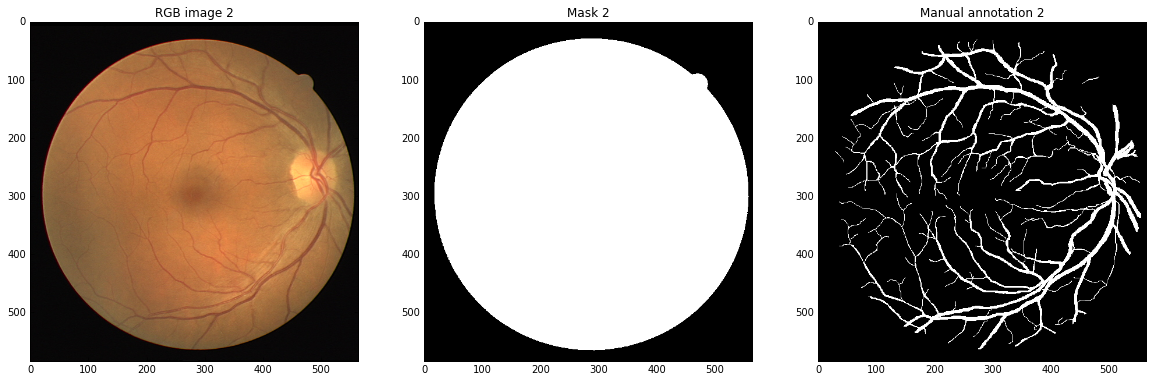

(584, 565, 3)


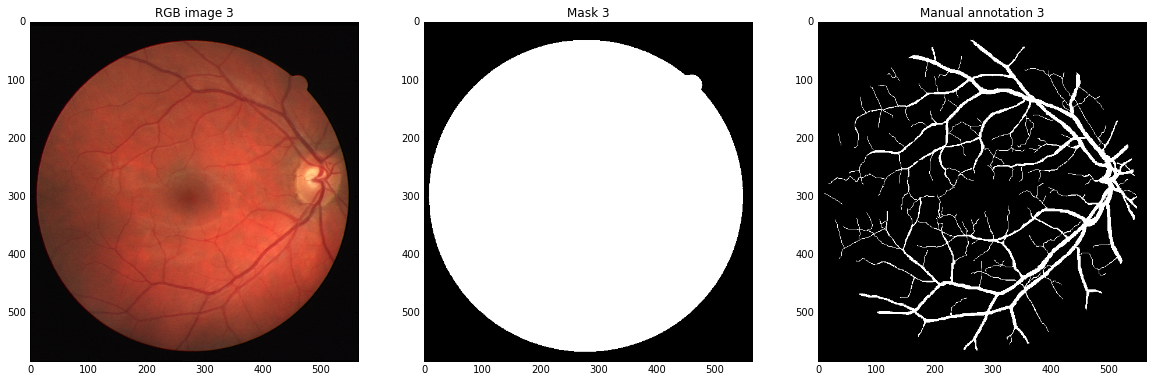

(584, 565, 3)


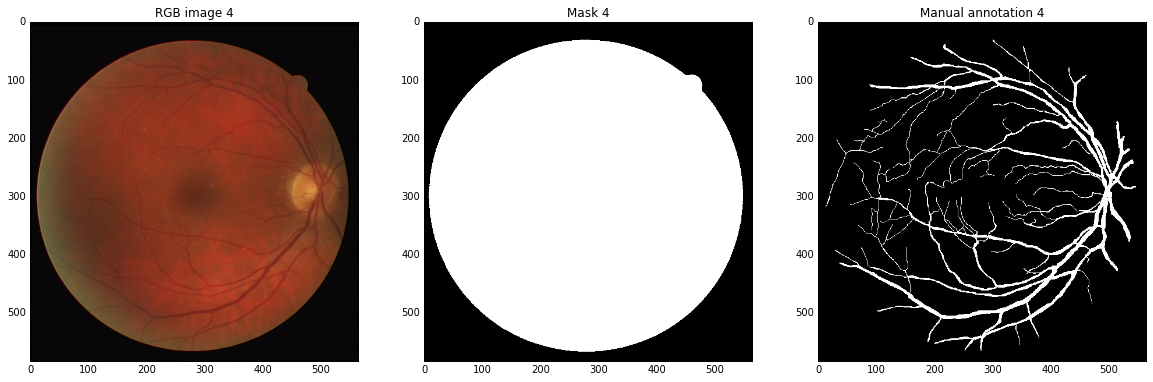

(584, 565, 3)


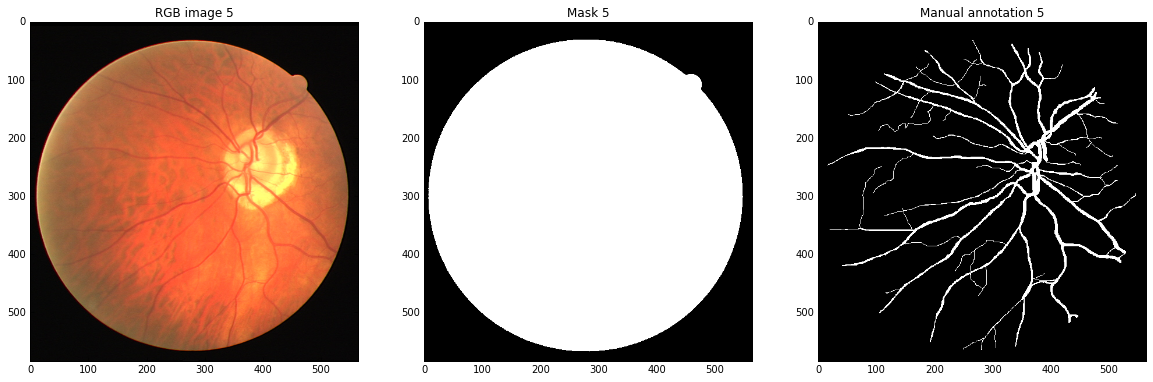

(584, 565, 3)


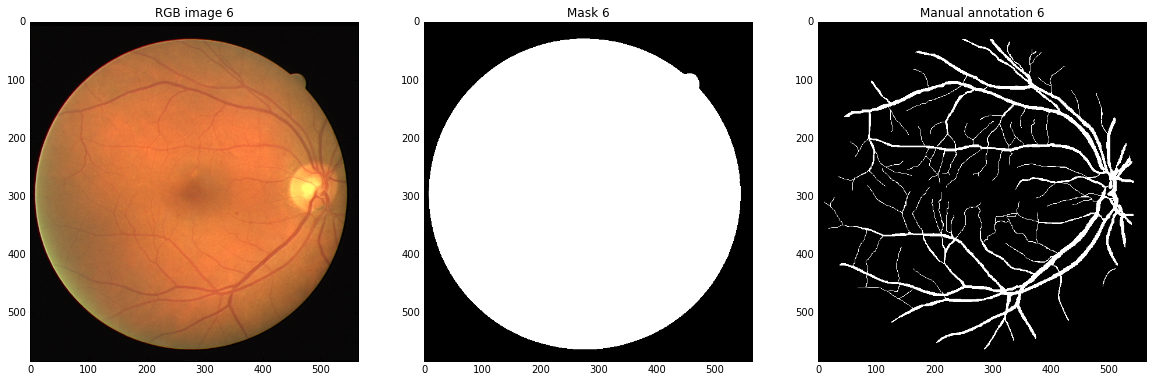

(584, 565, 3)


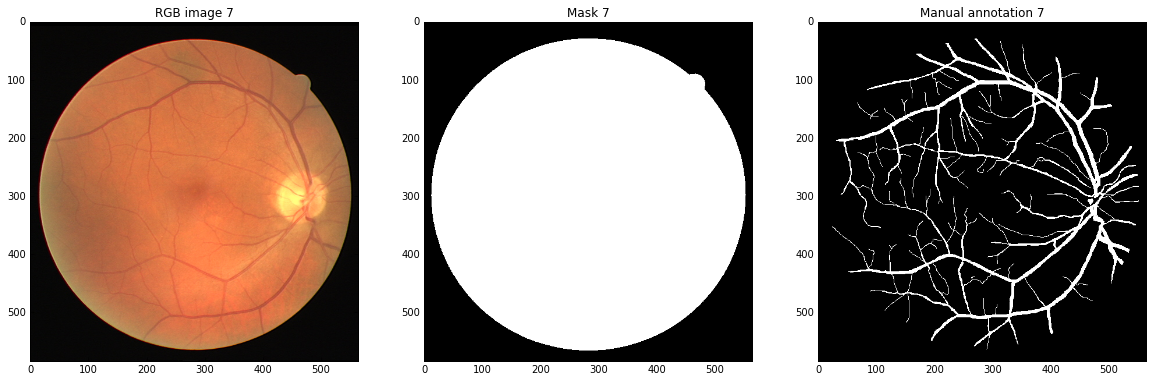

(584, 565, 3)


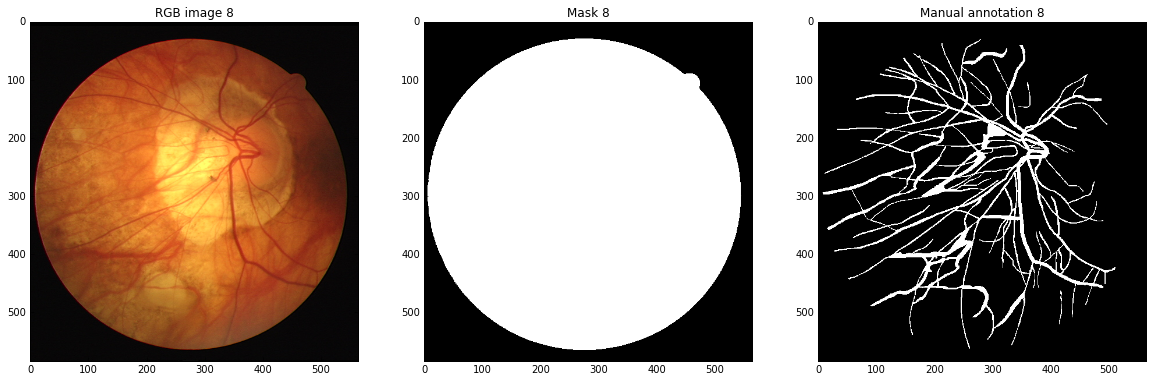

(584, 565, 3)


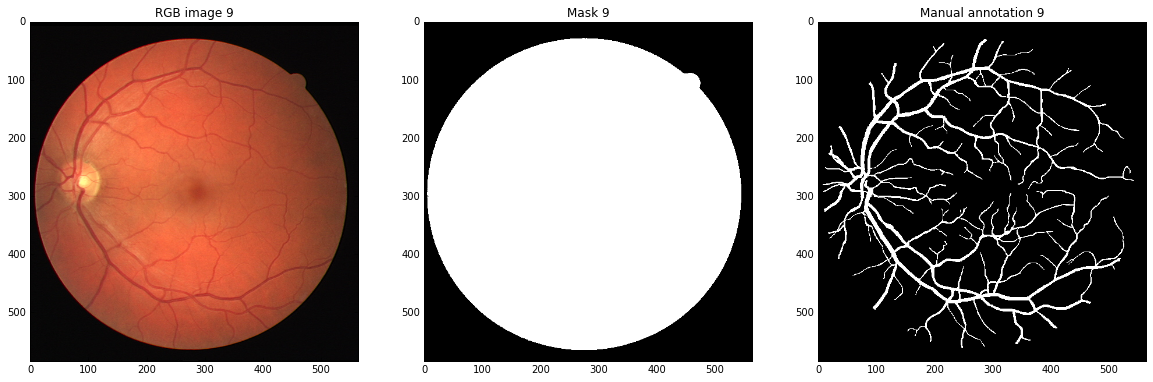

(584, 565, 3)


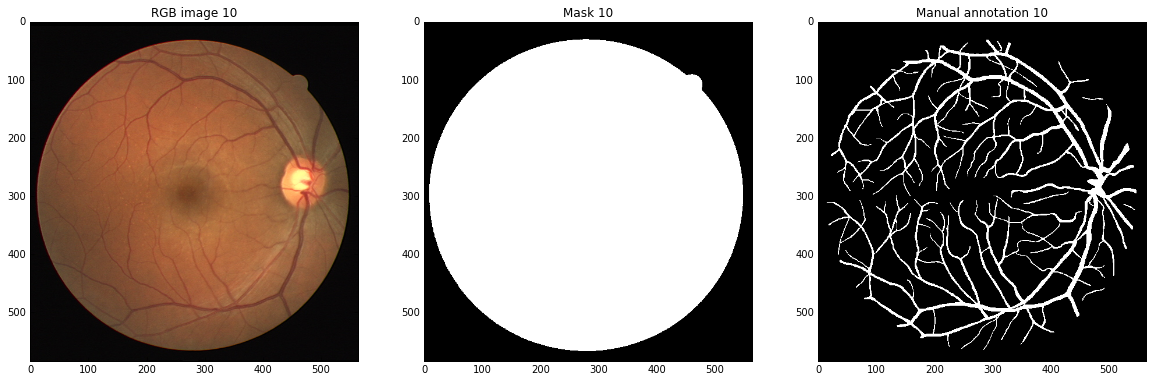

(584, 565, 3)


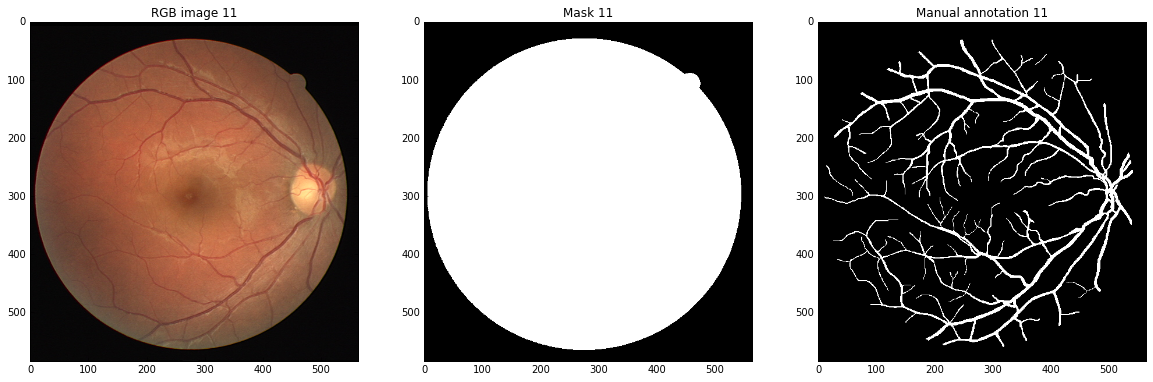

(584, 565, 3)


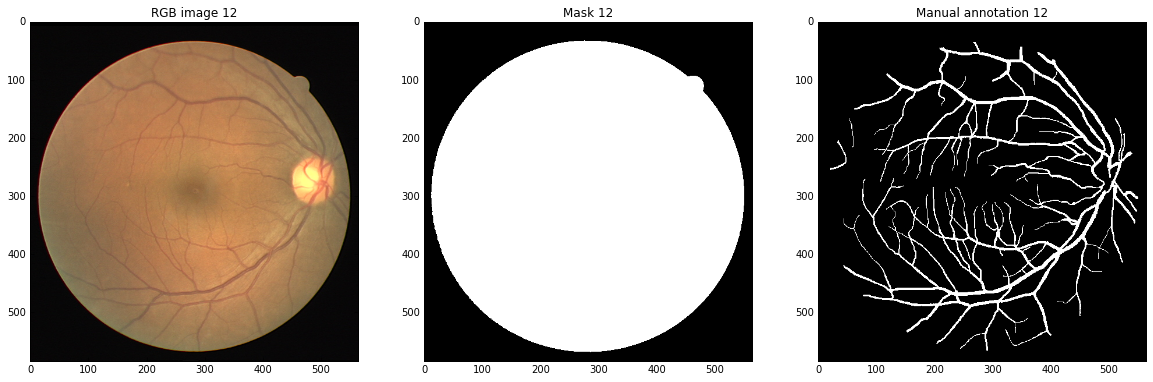

(584, 565, 3)


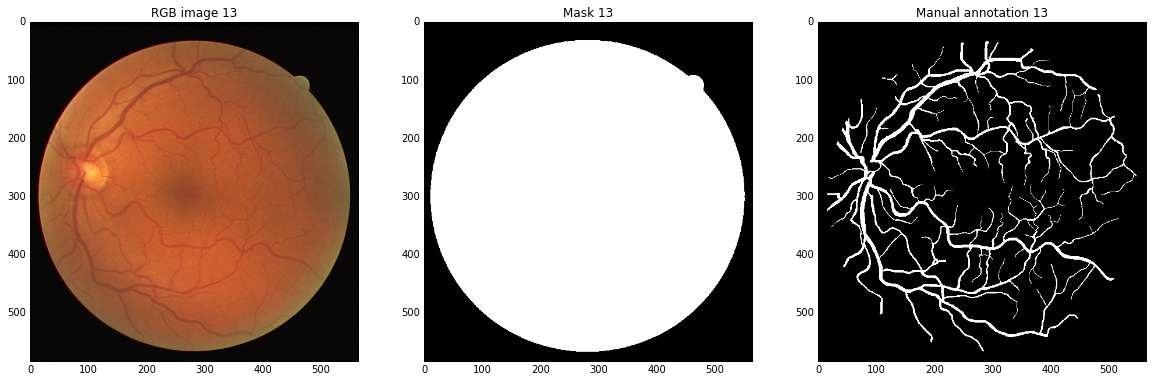

(584, 565, 3)


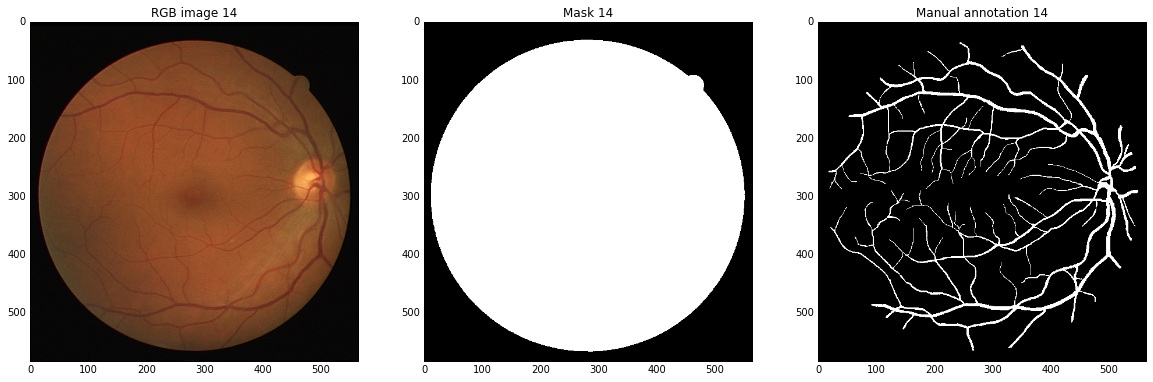

In [6]:
for i in range(len(tra_imgs)):
    show_image(i, tra_imgs, tra_msks, tra_lbls)

# Build a sample extractor
Differently from what done in the past two weeks, in this assignment we are going to implement a 'SampleExtractor' class, which extract random samples from a list of images, in order to **generate mini-batches on-the-fly**.
This means that you don't need to create a dataset beforehand and then use it to train you network, but you will just have a list of training images available, and patches will be extracted on-the-fly during training.
This strategy allows to save time in the preparation of your *static* dataset, and allows the use of a *dynamic* generation of mini-batches, where data augmentation can also be applied on the fly.
Note that this approach allows to test different strategies of data augmentation without the need for making a new dataset from scratch all the time.
We will implement two kind of data augmentation in the class ```SampleExtractor```:
* patch rotation
* patch flipping

In both cases, the event will occur at random, meaning that during patch extraction, some of the extracted patches will be randomly transformed. Furthermore, the rotation angle will also be defined randomly, which means that the combination of different patches used for training is in practice infinite (of course there is a limitation at some point).

In [6]:
class SampleExtractor:

    def __init__(self, patch_size, imgs, msks, lbls, max_rotation=0, rnd_flipping=False):
        self.patch_size = patch_size  #y,x
        self.img_array = np.zeros([len(imgs), 584, 565])
        self.msk_array = np.zeros([len(msks), 584, 565])
        self.lbl_array = np.zeros([len(lbls), 584, 565])
        
        # parameters used for data augmentation on-the-fly
        self.max_rotation = max_rotation # float
        self.rnd_flipping = rnd_flipping # boolean
     
        ## load images, masks, and labels in memory
        for i, (img, msk, lbl) in enumerate(zip(imgs, msks, lbls)):
            self.img_array[i] = np.asarray(Image.open(img))[:,:,1] # green channel
            self.msk_array[i] = np.asarray(Image.open(msk))/255.0 # (0, 1)
            self.lbl_array[i] = np.asarray(Image.open(lbl))
            
        ## precalculate positive and negative indices inside the retina mask
        self.pos_idx = np.array(np.where(np.logical_and(self.lbl_array > 0, self.msk_array == 1))) #indexed as [image, y, x]
        self.neg_idx = np.array(np.where(np.logical_and(self.lbl_array == 0, self.msk_array == 1)))  #indexed as [image, y, x]
        
        print 'shape of positive indexes: {}'.format(self.pos_idx.shape)
        print 'shape of negative indexes: {}'.format(self.neg_idx.shape)
                
    def get_rnd_rotation(self):
        ''' Return a 2x2 rotation matrix to rotate by a random angle phi. 
            The angle should in the range of -self.max_rotations to +self.max_rotations. '''
        if self.max_rotation == 0:
            return np.eye(2) # identity matrix
        else:
            #create a random rotation matrix 'rot_mat' in the range of -'self.max_rotations' to +'self.max_rotations'
                        
            # >>> YOUR CODE STARTS HERE <<<
            theta = np.radians(np.random.uniform(-self.max_rotation, self.max_rotation))
            c, s = cos(theta), sin(theta)
            rot_mat = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
            rot_mat = np.array([[c, -s], [s, c]])
            # >>> YOUR CODE ENDS HERE <<<   
            
            return rot_mat # 2x2 np.array    
    
    def rnd_flip(self, X):
        ''' Return a flipped version of the input patch X.
            The kind of flip and the probability that the event happens
            should be based on a random event. '''       
        
        # write a function that randomly flips the input image
        # >>> YOUR CODE STARTS HERE <<<
        if np.random.rand() > 0.5:
            X = np.flip(X, np.random.choice([0, 1]))
        # >>> YOUR CODE ENDS HERE <<<   
        return X
    
    def extract_sample(self, image, loc_y, loc_x):
        ps_y, ps_x = self.patch_size
        
        ## get a random rotation matrix
        rot_mat = self.get_rnd_rotation()
        
        ## Shift coordinate system to the center of the image
        ## for more information http://stackoverflow.com/questions/20161175/how-can-i-use-scipy-ndimage-interpolation-affine-transform-to-rotate-an-image-ab
        c_in = loc_y, loc_x
        c_out = np.array([ps_y/2, ps_x/2])
        offset = c_in - c_out.dot(rot_mat)
        
        ## extract the patch and apply the rotation matrix
        X = affine_transform(self.img_array[image], rot_mat.T, offset=offset, output_shape=(ps_y, ps_x), order=1)/255.0   
        ## extract the label
        Y = int(self.lbl_array[image,loc_y,loc_x] > 0)
        
        ## apply random flipping
        if self.rnd_flipping:
            X = self.rnd_flip(X)
            
        return X, Y       
           
    def get_random_sample_from_class(self, label):
        ''' Extract a patch with a given label. '''
        
        # >>> YOUR CODE STARTS HERE <<<
        # tip: use 'self.pos_idx' and 'self.neg_idx'
        
        if label == 0: 
            image = np.random.choice(len(self.img_array))
            indices = np.where(self.neg_idx[0] == image)[0]
            patch = np.random.choice(indices)
            
            loc_y, loc_x = self.neg_idx[1:, patch]
        else:
            image = np.random.choice(len(self.img_array))
            indices = np.where(self.pos_idx[0] == image)[0]
            patch = np.random.choice(indices)
            
            loc_y, loc_x = self.pos_idx[1:, patch]
        # >>> YOUR CODE ENDS HERE <<<   

        return self.extract_sample(image, loc_y, loc_x) 

A convenience function to visualize the output of the patch extractor

In [7]:
def visualize_samples(sampling_function, label):
    for i in range(5):
        X, Y = sampling_function(label)
        plt.subplot(1,5,i+1)
        plt.imshow(X, cmap='bone', vmin=0, vmax=1); plt.title('patch: ' + str(i) + " , class: " + str(Y))

## Create the basic random sample extractor
Implement the ```get_random_sample_from_class()``` function in the class above. You can use the functions below to test if the output makes sense.


In [8]:
# Here we test the patch extractor without random rotation and without flipping.

# define a random sample extractor object
random_sample_extractor = SampleExtractor((31,31),tra_imgs, tra_msks, tra_lbls, max_rotation=0, rnd_flipping=False)

shape of positive indexes: (3, 395876)
shape of negative indexes: (3, 2783477)


Execute the following cells several times to see if the results you get make sense.

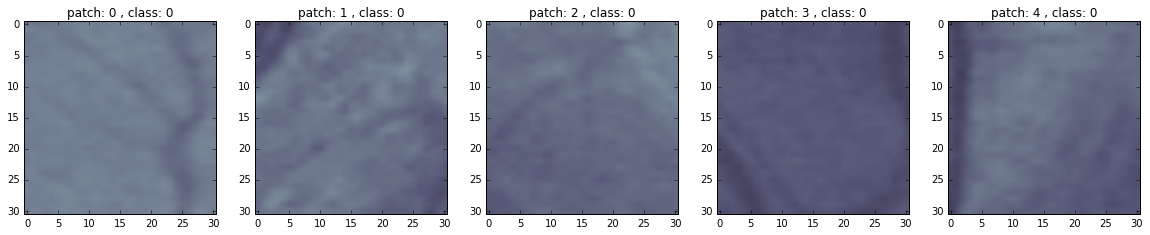

In [9]:
# visualize examples of background (label = 0)
visualize_samples(random_sample_extractor.get_random_sample_from_class, 0)

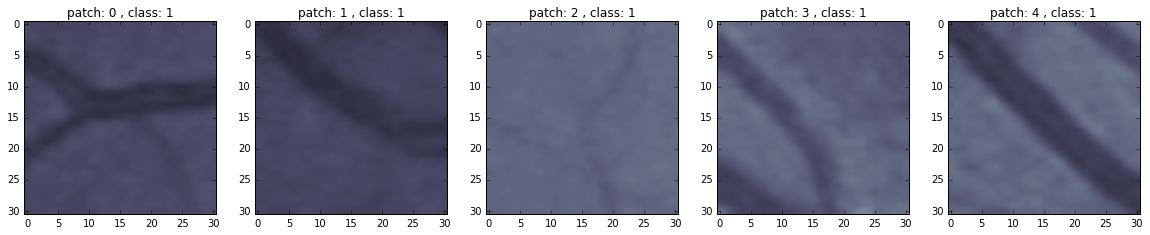

In [10]:
# visualize example of vessels (label = 1)
visualize_samples(random_sample_extractor.get_random_sample_from_class, 1)

## Implement rotation augmentation

Implement the ```get_rnd_rotation()``` function in the class above.
You can use the functions below to test if the output makes sense.

In [11]:
#Now we enable rotation, and test it again.
random_sample_extractor = SampleExtractor((31,31),tra_imgs, tra_msks, tra_lbls, max_rotation=15, rnd_flipping=False)

shape of positive indexes: (3, 395876)
shape of negative indexes: (3, 2783477)


In [12]:
x, y = random_sample_extractor.get_random_sample_from_class(1)
x.shape, y

((31, 31), 1)

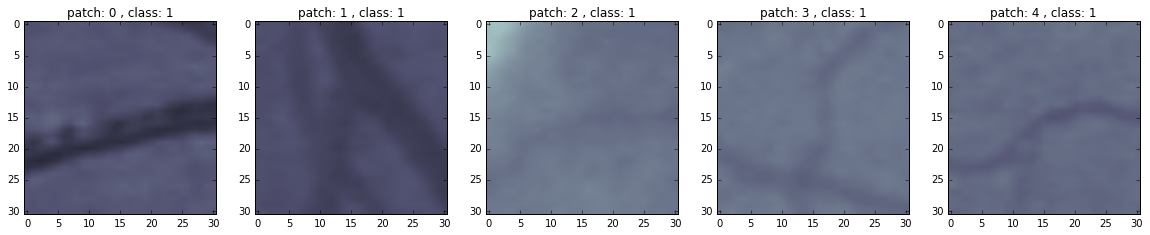

In [13]:
# visualize example of vessels (label = 1)
visualize_samples(random_sample_extractor.get_random_sample_from_class, 1)

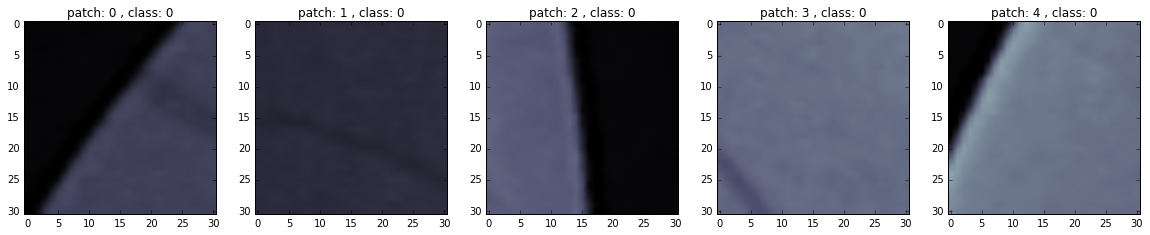

In [14]:
# visualize example of background (label = 0)
visualize_samples(random_sample_extractor.get_random_sample_from_class, 0)

## Implement mirroring augmentation
Implement the ```rnd_flip()`` function in the class above.
You can use the functions below to test if the output makes sense.

In [15]:
random_sample_extractor = SampleExtractor((31,31),tra_imgs, tra_msks, tra_lbls, max_rotation=0, rnd_flipping=True)

shape of positive indexes: (3, 395876)
shape of negative indexes: (3, 2783477)


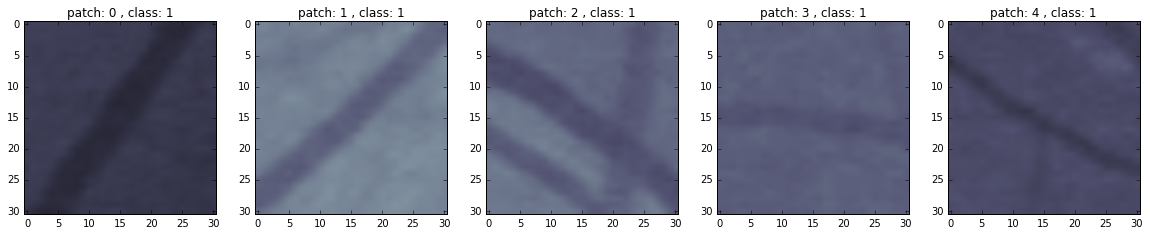

In [16]:
# visualize example of vessels (label = 1)
visualize_samples(random_sample_extractor.get_random_sample_from_class, 1)

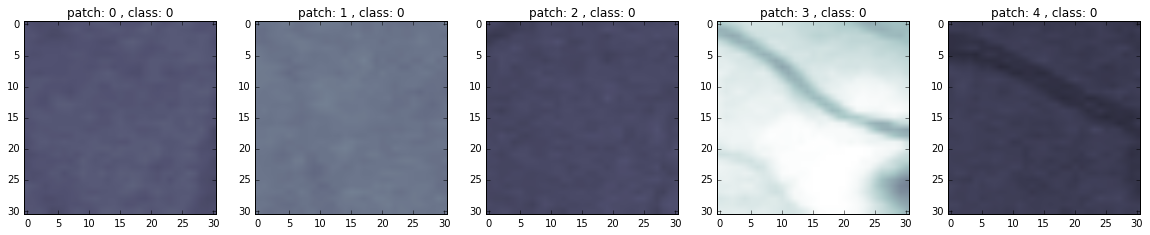

In [17]:
# visualize example of background (label = 0)
visualize_samples(random_sample_extractor.get_random_sample_from_class, 0)

## Implement a batch extractor 

We now implement a batch extractor. This class is based on the sample extractor, but it just makes mini-batches of random samples. The mini-batches will be used to train your network, and as we have seen, there will be random data augmentation there.

In [18]:
class BatchExtractor:

    def __init__(self, sample_extractor, batch_size, class_balancing = False):
        self.batch_size = batch_size
        self.class_balancing = class_balancing
        self.sample_extractor = sample_extractor
        
    def convert_to_onehot(self, Y, num_classes):  #convert a [b,1,h,w] label tensor to a [b,number_of_categories,h,w] tensor in one_hot form
        one_hot = np.zeros((Y.shape[0], num_classes, Y.shape[2], Y.shape[3]))
        for i in range(num_classes):
            one_hot[:,i:i+1,:,:] = Y.astype(np.int) == i              
        return one_hot
        
    def get_random_batch_balanced(self):
        se = self.sample_extractor
        
        # >>> YOUR CODE STARTS HERE <<<
        # Write a function to extract a batch with balanced classes using the previously created patch extractor 
        # Use the 'get_random_patch_from_class' function you implemented
        X_batch, Y_batch = [], []
        
        if class_balancing:
            pos = int(np.ceil(batch_size / 2.))
            neg = batch_size - pos

            for _ in range(pos):
                x_p, y_p = se.get_random_sample_from_class(1)  
                X_batch.append(x_p[np.newaxis, :])
                Y_batch.append(np.array([y_p])[:, np.newaxis, np.newaxis])

            for _ in range(neg):
                x_n, y_n = se.get_random_sample_from_class(0)
                X_batch.append(x_n[np.newaxis, :])
                Y_batch.append(np.array([y_n])[:, np.newaxis, np.newaxis])
                
        else: 
            for _ in range(batch_size):
                label = np.random.choice([0, 1])
                x, y = se.get_random_sample_from_class(label)   
                X_batch.append(x[np.newaxis, :])
                Y_batch.append(np.array([y])[:, np.newaxis, np.newaxis])
        
        X_batch, Y_batch = np.stack(X_batch), np.stack(Y_batch)
        # >>> YOUR CODE ENDS HERE <<<   
        
        # X_batch should be a 4D array indexed as [batchsize, channels, y, x]
        # Y_batch should be a 4D array indexed as [batchsize, 1, 1, 1] and will be [batchsize, 2, 1, 1] after onehot conversion
        # the batch should contains 50% positive patches and 50% negative patches
        
        return X_batch, self.convert_to_onehot(Y_batch,2)

    

## Build the fully convolutional CNN

We start with defining the network architecture in Lasagne.
The network we are using is a socalled **fully convolutional network**, a network that does not contain any fully connected layers. This type of network is well suited for image segmentation as a very efficient implementation can be used. 

A direct, but naive approach to pixel classification using a CNN would be to extract a patch around every pixel and assign the output back to the pixel location. This naive approach is computationally inefficient, because when we move our 31x31 patch by
one pixel to classify the next pixel, 30x31 pixels of the new patch are identical to the previous patch, and we would apply the same convolutions many times over.


As the network we use here only contains convolutional filters, i.e. the spatial structure is kept intact, the whole network can be thought of as a single large convolutional filter that can be applied to the whole image at once. This speeds up the classification greatly and allows full image segmentation in seconds!

What is important for fully convolutional networks is that the size of the feature maps within the network goes down to exactly 1 for the final feature map. This requires some computation, but luckily it is pretty straightforward. 

Assume:

    - i = Input featuremap size
    - f = Convolution filter size (uneven)
    - max pooling size = 2
    

Then:
Output size of a feature map  after convolution with a convolution filter of size f:

    output_size = input_size -(f-1)

Output size of a feature map  after max pooling by a factor 2:

    output_size = floor(input_size/2)
    

Let's define a baseline model:
* input layer (given)
* 32 filters of 3x3
* 32 filters of 3x3
* pooling
* 64 filters of 3x3
* 64 filters of 3x3
* pooling
* 128 filters of ?x?
* 64 filters of 1x1
* 2 filters of 1x1 (given)


In [20]:
# Define your network builder function. 

def build_network(input_tensor):
    # define the inputlayer
    network = L.InputLayer(shape=(None, 1, None, None), input_var = input_tensor)
    
 

    # >>> YOUR CODE STARTS HERE <<<
    # Implement the fully convolutional network
    network = L.Conv2DLayer(network, 
                            num_filters=32, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.Conv2DLayer(network, 
                            num_filters=32, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = L.Conv2DLayer(network, 
                            num_filters=128, 
                            filter_size=(4, 4),
                            nonlinearity=lasagne.nonlinearities.rectify)
    print network.output_shape
    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(1, 1),
                            nonlinearity=lasagne.nonlinearities.rectify)
    print network.output_shape
    
    # >>> YOUR CODE ENDS HERE <<< 

    # define the final layer. 
    # because we are now creating a fully convolutional layer, the last layer does NOT contain a softmax function.
    # the softmax function will be implemented later in a different way allowing a pixelwise loss
    final_layer = L.Conv2DLayer(network, 
                                num_filters=2, 
                                filter_size=(1,1), 
                                nonlinearity=lasagne.nonlinearities.identity, 
                                W=lasagne.init.GlorotUniform())  
    print final_layer.output_shape
    return final_layer

def softmax(network):
    output = lasagne.layers.get_output(network)
    exp = T.exp(output - output.max(axis=1, keepdims=True)) #subtract max for numeric stability (overflow)
    return exp / exp.sum(axis=1, keepdims=True)

def softmax_deterministic(network):
    output = lasagne.layers.get_output(network, deterministic=True)
    exp = T.exp(output - output.max(axis=1, keepdims=True)) #subtract max for numeric stability (overflow)
    return exp / exp.sum(axis=1, keepdims=True)

## Define the training, validation and evaluation function

In [21]:
def training_function(network, input_tensor, target_tensor, learning_rate, use_l2_regularization=False, l2_lambda=0.000001):
    
    # Get the network output and calculate metrics.
    network_output = softmax(network)
        
    if use_l2_regularization:
        l2_loss = lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2)
        loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean() + l2_lambda * l2_loss
    else:
        loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean()
        
    accuracy = T.mean(T.eq(T.argmax(network_output, axis=1), T.argmax(target_tensor,axis=1)), dtype=theano.config.floatX)
    
    # Get the network parameters and the update function.                      
    network_params = L.get_all_params(network, trainable=True)
    weight_updates = lasagne.updates.sgd(loss, network_params, learning_rate=learning_rate)
    
    # Construct the training function.
    return theano.function([input_tensor, target_tensor], [loss, accuracy], updates=weight_updates)

In [22]:
def validate_function(network, input_tensor, target_tensor):
    
    # Get the network output and calculate metrics.
    network_output = softmax_deterministic(network)
    loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean()
    accuracy = T.mean(T.eq(T.argmax(network_output, axis=1), T.argmax(target_tensor,axis=1)), dtype=theano.config.floatX)  
    
    # Construct the validation function.
    return theano.function([input_tensor, target_tensor], [loss, accuracy])

In [23]:
def evaluate_function(network, input_tensor):
 
    # Get the network output and calculate metrics.
    network_output = softmax_deterministic(network)
    
    # Construct the evaluation function.
    return theano.function([input_tensor], network_output)

## Set parameters
Set the parameters to suitable values.
Certain paramters have a large influence on the performance of your network, try to find the optimal parameters for this problem!

In [25]:
learning_rate = .001
nr_epochs = 20
nr_iterations_per_epoch = 500
patch_size = (31,31)
batch_size = 128
max_rotation = 90
flipping = True
class_balancing = True
nr_validation_samples = 2
validation_batch_size = 128
network_name = 'default'

## Compile the theano functions

In [26]:
inputs = T.ftensor4('X') 
targets = T.ftensor4('Y')

network = build_network(inputs)

train_fn = training_function(network=network, input_tensor=inputs, target_tensor=targets, learning_rate=learning_rate,
                             use_l2_regularization=False, l2_lambda=0.000001)
validation_fn = validate_function(network=network, input_tensor=inputs, target_tensor=targets)
evaluation_fn = evaluate_function(network=network, input_tensor=inputs)

(None, 128, None, None)
(None, 64, None, None)
(None, 2, None, None)


Create the 
 - sample extractors
 - batch extractors
 - constant validation set
 - Initialize all monitoring statistics

In [27]:
random.seed(0)

sample_ex_train = SampleExtractor(patch_size, tra_imgs, tra_msks, tra_lbls, max_rotation=max_rotation, rnd_flipping=flipping)
batch_ex_train = BatchExtractor(sample_ex_train, batch_size, class_balancing=class_balancing)

sample_ex_val = SampleExtractor(patch_size, val_imgs, val_msks, val_lbls, max_rotation=max_rotation, rnd_flipping=flipping)
batch_ex_val = BatchExtractor(sample_ex_val, nr_validation_samples, class_balancing=class_balancing)

validation_X, validation_Y = batch_ex_val.get_random_batch_balanced()

tra_loss_lst = []
val_loss_lst= []
tra_acc_lst = []
val_acc_lst = []
best_val_acc = 0

shape of positive indexes: (3, 395876)
shape of negative indexes: (3, 2783477)
shape of positive indexes: (3, 173539)
shape of negative indexes: (3, 1188114)


## Main training loop

Now that we have a pipeline for creating batches on the fly, we can now train our fully convolutional network!
The following code trains for a certain amount of time, defined in the parameters section above, and will then evaluate the performance on our validation set. After plotting the results, the next epoch will start.
Try to optimize the parameters to get the best performance possible! (>90% accuracy should be possible!)

In [ ]:
# Main training loop
for epoch in range(nr_epochs):
    print('Epoch {}'.format(epoch+1))
    # training
    tra_losses = []
    tra_accs = []
    print('training...')
    for b in tqdm_notebook(range(0, nr_iterations_per_epoch), leave=False):
        X, Y = batch_ex_train.get_random_batch_balanced()     
        loss, accuracy = train_fn(X.astype(np.float32), Y.astype(np.float32))
        tra_losses.append(loss)
        tra_accs.append(accuracy)
    tra_loss_lst.append(np.mean(tra_losses))
    tra_acc_lst.append(np.mean(tra_accs))
            
    # validation
    val_losses = []
    val_accs = []
    print('validation...')
    for b in tqdm_notebook(range(0, nr_validation_samples, validation_batch_size), leave=False):
        X = validation_X[b:min(b+validation_batch_size, nr_validation_samples)]
        Y = validation_Y[b:min(b+validation_batch_size, nr_validation_samples)]
        loss, accuracy = validation_fn(X.astype(np.float32), Y.astype(np.float32))
        print loss
        val_losses.append(loss)
        val_accs.append(accuracy)
    val_loss_lst.append(np.mean(val_losses))
    val_acc_lst.append(np.mean(val_accs))   
    #continue
    if np.mean(val_accs) > best_val_acc:
        best_val_acc = np.mean(val_accs)
        # save network
        params = L.get_all_param_values(network)
        np.savez(os.path.join('./', network_name+'.npz'), params=params)

    # plot learning curves
    fig = plt.figure(figsize=(10, 5))
    tra_loss_plt, = plt.plot(range(len(tra_loss_lst)), tra_loss_lst, 'b')
    val_loss_plt, = plt.plot(range(len(val_loss_lst)), val_loss_lst, 'g')
    tra_acc_plt, = plt.plot(range(len(tra_acc_lst)), tra_acc_lst, 'm')
    val_acc_plt, = plt.plot(range(len(val_acc_lst)), val_acc_lst, 'r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend([tra_loss_plt, val_loss_plt, tra_acc_plt, val_acc_plt], 
                ['training loss', 'validation loss', 'training accuracy', 'validation accuracy'],
                loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_val_acc))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.2)

Epoch 1
training...


## Evaluate the performance on the test set and submit to Challenger

We can now apply the trained fully convolutional network on our independent test set.

Load the images:

In [ ]:
# test images
tes_img_dir = os.path.join(data_dir, 'test', 'images')
tes_msk_dir = os.path.join(data_dir, 'test', 'mask')

tes_imgs = sorted(get_file_list(tes_img_dir, 'tif')[0])
tes_msks = sorted(get_file_list(tes_msk_dir, 'gif')[0])

result_output_folder = os.path.join(data_dir, 'test', 'results')
if not(os.path.exists(result_output_folder)):
    os.mkdirs(result_output_folder)

## Apply the trained network to the images

In [ ]:
# indicate the name of the network for this test
network_name = 'test'

# initialize the network used in this experiment (this may change)
network = build_network(inputs)
npz = np.load('./'+network_name+'.npz') # load stored parameters
lasagne.layers.set_all_param_values(network, npz['params']) # set parameters

# one forward pass on the test set
threshold = 0.5
for f in range(len(tes_imgs)):    
    
    # open image
    img = np.asarray(Image.open(tes_imgs[f]))
    print img.shape
    
    # exrtact green channel and normalize
    img_g = img[:,:,1].squeeze().astype(float)/255.0
    
    # zero padding to apply fully-convolutional network
    img_g_padded = np.pad(img_g, ((patch_size[0]//2,patch_size[0]//2),
                                  (patch_size[1]//2, patch_size[1]//2)), 'constant', constant_values = [0,0])
    
    # forward pass
    probability = evaluation_fn(np.expand_dims(np.expand_dims(img_g_padded.astype(np.float32), axis=0),axis=0))
    probability = probability[0,1,:,:]
    
    # binary version by thresholding
    thresholded_image = probability > threshold
    print thresholded_image.shape
    
    # show results
    plt.subplot(1,3,1)
    plt.imshow(img_g_padded, cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(probability, cmap='jet')
    plt.subplot(1,3,3)
    plt.imshow(thresholded_image, cmap='gray')
    plt.show()

## Shift and stitch
You can immediately notice that an output is not produced for every pixel value.
This is due to the downsampling that is performed in the network. 
The network acts like a filter of size 'patch_size' (the size of the training patches) with a stride of 2^(number of max pooling operations present in the network). So with 2 max pooling operations in the network we obtain a stride of 4 pixels.

If we want to produce an output for every pixel, we can use a **shift-and-stitch** technique, i.e. we shift the input image by one pixel at a time and then stitch the results. More information can be found in this paper: P. Sermanet et al. Overfeat: Integrated recognition, localization and detection using convolutional networks. https://arxiv.org/abs/1312.6229

In the next function you will have to implement ```shift_and_stitch()```.

In [ ]:
def shift_and_stitch(im, patch_size, stride):
    ''' Return a full resolution segmentation by segmenting shifted versions
    of the input 'im' and stitching those segmentations back together. 
    The stride determines how many times the image should be shifted in the x and y direction'''
    
    patch_size = patch_size[0] 
    
    ## create the output shape, the output image is made a bit bigger to allow the stitched versions to be added. 
    ## the extra parts will be cut off at the end
    output = np.zeros([im.shape[0]+2*stride, im.shape[0]+2*stride])
    
    # the input image has to be padded with zeros to allow shifting of the image. 
    # pad input image (half filter size + stride)
    im_padded = np.pad(im, ((patch_size//2, patch_size//2 + stride),
                            (patch_size//2, patch_size//2 + stride)), 'constant', constant_values = [0,0])    
    im_p_sh = im_padded.shape
    
    
    # Now implement a loop that:
    # - obtains a shifted version of the image
    # - applies the fully convolutional network
    # - and places the network output in the output of this function
        
    for row in range(0, stride):
        for col in range(0, stride):   
    
            # >>> YOUR CODE STARTS HERE <<<
        
            # >>> YOUR CODE ENDS HERE <<<  
    
    return output[0:im.shape[0], 0:im.shape[1]] 

### Apply shift-and-stitch
When you have succesfully implemented the shift and stitch method you can use it in the following function to segment the retinal vessels at full resolution and submit your results to the challenger framework

In [ ]:
# define these parameters
stride = None
threshold = None

f = 0
for img, msk in zip(tes_imgs,tes_msks):  
    
    img = np.asarray(Image.open(img))
    img_g = img[:,:,1].squeeze().astype(float)/255.0  
    msk = np.asarray(Image.open(msk))/255
    
    probability = shift_and_stitch(img_g, patch_size, stride)
    output = (probability > threshold) * msk
        
    plt.subplot(1,3,1)
    plt.imshow(img_g)
    plt.subplot(1,3,2)
    plt.imshow(probability)
    plt.subplot(1,3,3)
    plt.imshow(output)
    plt.show()
    
    result = Image.fromarray((255*output).astype('uint8'))
    result.save(os.path.join(result_output_folder, str(f+1) + "_mask.png")) 
    f += 1

## Submit your results to Challengr

In [ ]:
import challenger

challenger.submit_results({'username': '',
                           'password': ''},
                          result_output_folder,
                          {'notes': ''})

# Additional data augmentation
As an optional task, you can implement additional data augmentation by adding functions to the ```SampleExtractor``` class. You can retrain the proposed architecture and check if further data augmentation can improve results.
Furthermore, you can modify the network architecture by adding/removing layers, adding dropout, L2 regularization, batch normalization, etc. **Be creative!**


# Submission
Document all your experiments, add new cells to this notebook if necessary.
Submit the notebook fully executed to Freerk (freerk.venhuizen@radboudumc.nl) and Mehmet (mehmet.dalmis@radboudumc.nl). 